# Supplemental Figures

This notebook is for generation of supplemental figures and additional analyses.

In [1]:
import os
import sys
sys.path.append("/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/")

import glob
from collections import defaultdict
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from soundfile import SoundFile

from zf_data import Tsvk, load_trials
from zf_data.load_data import load_lesion_summary_table, load_subject_lesion_tables
from zf_data.stats import false_discovery, likelihood_ratio_test, two_to_one_tail
from zf_data.plotting import (
    border,
    color_by_reward,
    draw_k_axis,
    draw_logor_axes_markers,
    draw_probability_axes_markers,
    figure_cm,
    fig_grid,
    smoothhist,
    shaded_line,
)
from zf_data.utils import parse_p, setup_mpl_params
from zf_data.constants import *

%load_ext autoreload
%autoreload 2

In [2]:
setup_mpl_params()

In [3]:
SAVE_FIGS = True  #@param {type: "boolean"}
FIGDIR = "figures/svg_originals"  #@param {type: "string"}
FIGDIR = Path(FIGDIR)

FIGDIR.mkdir(parents=True, exist_ok=True)

def savedir(rel_path):
    """Return the save path relative to FIGDIR"""
    return str(FIGDIR / rel_path)

# JNeurosci column sizes in cm
COL1 = 8.5  #@param {type: "number"}
COL1_5 = 11.6  #@param {type: "number"}
COL2 = 17.6  #@param {type: "number"}


In [4]:
def get_or_create_Tsvk(df: pd.DataFrame, k_max: int = None) -> Tsvk:
    """Create a Tsvk instance from a dataframe, or return a cached one for that data
    
    If the df.index and k_max match a previously computed Tsvk, return that one. Otherwise,
    instantiate a new Tsvk() instance.
    
    Tsvk instances are hashed by a tuple of the dataframe index and k_max requested.
    """
    key = (tuple(df.index), k_max)
    if key not in get_or_create_Tsvk.cache:
        get_or_create_Tsvk.cache[key] = Tsvk(df, k_max=k_max)
    return get_or_create_Tsvk.cache[key]
get_or_create_Tsvk.cache = {}

## Load Data

In [5]:
df = load_trials()

## Table S3

A summary of lesion volume and off-target effects.

In [6]:
load_lesion_summary_table().sort_values("TotalVolume (mm^3)").round(3)

,Subject,L-CD (mm^3),L-CV (mm^3),L-RD (mm^3),L-RV (mm^3),R-CD (mm^3),R-CV (mm^3),R-RD (mm^3),R-RV (mm^3),TotalVolume (mm^3),HP,L,NCL,Cb,CM,HVC
8,XXXHpi0038M,0.090,0.003,0.062,0.000,0.076,0.000,0.000,0.000,0.231,2,0,0,1,0,0
9,GraWhi4040F,0.013,0.013,0.000,0.000,0.165,0.127,0.004,0.000,0.322,0,0,0,0,0,0
6,RedHpi0710F,0.029,0.046,0.102,0.005,0.010,0.027,0.093,0.078,0.390,1,0,2,0,1,1
4,GreBlu5039F,0.115,0.026,0.193,0.000,0.051,0.009,0.000,0.000,0.394,2,1,0,1,1,0
3,GreBla3404M,0.378,0.133,0.008,0.000,0.015,0.059,0.000,0.000,0.593,1,0,0,0,0,0
1,XXXBlu0031M,0.135,0.043,0.182,0.053,0.000,0.000,0.100,0.106,0.619,0,1,1,0,1,0
5,WhiBlu5805F,0.091,0.025,0.202,0.005,0.014,0.000,0.296,0.000,0.634,0,2,3,0,1,0
0,BlaGre1349M,0.099,0.000,0.112,0.000,0.406,0.032,0.000,0.000,0.649,1,0,1,0,0,0
7,XXXOra0037F,0.035,0.325,0.000,0.000,0.056,0.127,0.018,0.132,0.693,0,0,2,0,0,0
2,HpiGre0651M,0.096,0.121,0.140,0.028,0.139,0.121,0.206,0.067,0.919,0,0,1,0,1,1


## Figure S6-2

Scores on 1v1 days before and after lesion of S1, and S2.

In [7]:
def figure_S1(call_type: str, treatment: str, ax: plt.Axes = None):
    """Plot the overall odds ratios when the stimuli are well learned
    """
    if ax is None:
        ax = plt.gca()
        
    colormap = {
        "NCM": NCM_COLOR,
        "HVC": HVC_COLOR,
        "CTRL": CTRL_COLOR
    }

    tsvk_S1_pre = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
        & (df.StimulusCallType == call_type)
        & df.LadderStage.isin(["DCvsDC_1v1", "SovsSo_1v1"])
    ])
    tsvk_S1_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
        & (df.StimulusCallType == call_type)
        & df.LadderStage.isin(["DCvsDC_1v1", "SovsSo_1v1"])
    ])
    tsvk_S2_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.SubjectTreatment == treatment)
        & (df.StimulusCallType == call_type)
        & df.LadderStage.isin(["DCvsDC_1v1_S2", "SovsSo_1v1_S2"])
    ])
        
    scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
    scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
    scores_3 = tsvk_S2_post.fisher_exact_by_subjects(side="greater")

    all_scores = scores_1.join(
        scores_2.set_index("Subject"), on="Subject", rsuffix="-s1post"
    ).join(scores_3.set_index("Subject"), on="Subject", rsuffix="-s2post")

    mean_1 = np.mean(scores_1["logOR"])
    mean_2 = np.mean(scores_2["logOR"])
    mean_3 = np.mean(scores_3["logOR"])
    
    sem_1 = np.std(scores_1["logOR"]) / np.sqrt(len(scores_1))
    sem_2 = np.std(scores_2["logOR"]) / np.sqrt(len(scores_2))
    sem_3 = np.std(scores_3["logOR"]) / np.sqrt(len(scores_3))

    ax.plot([0, 1, 2], all_scores[["logOR", "logOR-s1post", "logOR-s2post"]].to_numpy().T, alpha=1, linewidth=1, color="0.8")

    ax.scatter(0 * np.ones(len(scores_1)), scores_1["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    ax.scatter(1 * np.ones(len(scores_2)), scores_2["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    ax.scatter(2 * np.ones(len(scores_3)), scores_3["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    
    print()
    print(" One-sample t-tests for logOR > 0:")
    print(" =================================")
    
    dof = len(all_scores) - 1    
    tstat, pvalue = scipy.stats.ttest_1samp(all_scores["logOR"], 0, alternative="greater")
    pvalue = two_to_one_tail(pvalue, tstat, 0, side="high")
    print(f"S1, t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")

    dof = len(all_scores) - 1    

    tstat, pvalue = scipy.stats.ttest_1samp(all_scores["logOR-s1post"], 0, alternative="greater")
    pvalue = two_to_one_tail(pvalue, tstat, 0, side="high")
    print(f"S1', t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")
    dof = len(all_scores) - 1    

    tstat, pvalue = scipy.stats.ttest_1samp(all_scores["logOR-s2post"], 0, alternative="greater")
    pvalue = two_to_one_tail(pvalue, tstat, 0, side="high")
    print(f"S2', t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")

    print()
    ax.errorbar(
        [0.1, 1.1, 2.1], 
        [mean_1, mean_2, mean_3], 
        2 * np.array([sem_1, sem_2, sem_3]),
        linewidth=1.5, markersize=4, markerfacecolor="white", color=colormap[treatment], marker="d")
    
    

Figure Dimensions 10.60cm x 3.00cm
Song NCM
--------

 One-sample t-tests for logOR > 0:
S1, t(7) = 6.03, p < 0.001 (***)
S1', t(7) = 5.40, p < 0.001 (***)
S2', t(7) = 4.93, p < 0.001 (***)

DC NCM
--------

 One-sample t-tests for logOR > 0:
S1, t(7) = 8.37, p < 0.001 (***)
S1', t(7) = 5.26, p < 0.001 (***)
S2', t(7) = 3.80, p = 0.002 (**)

SO HVC
--------

 One-sample t-tests for logOR > 0:
S1, t(6) = 6.06, p < 0.001 (***)
S1', t(6) = 5.20, p = 0.001 (***)
S2', t(6) = 6.02, p < 0.001 (***)

DC HVC
--------

 One-sample t-tests for logOR > 0:
S1, t(6) = 3.99, p = 0.002 (**)
S1', t(6) = 6.65, p < 0.001 (***)
S2', t(6) = 4.79, p = 0.001 (***)

SO CTRL
--------

 One-sample t-tests for logOR > 0:
S1, t(3) = 3.95, p = 0.007 (**)
S1', t(3) = 5.30, p = 0.003 (**)
S2', t(3) = 10.42, p < 0.001 (***)

DC CTRL
--------

 One-sample t-tests for logOR > 0:
S1, t(3) = 22.36, p < 0.001 (***)
S1', t(3) = 6.85, p = 0.002 (**)
S2', t(3) = 3.65, p = 0.009 (**)



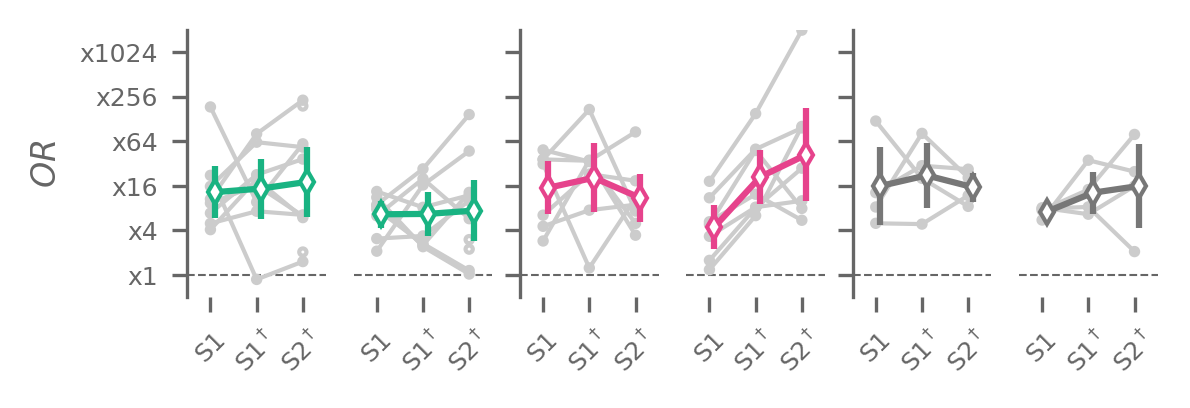

In [8]:
fig = figure_cm(COL1_5 - 1, 3, dpi=300)
axes = fig.subplots(1, 6)

print("Song NCM")
print("--------")
figure_S1("SO", "NCM", ax=axes[0])

print("DC NCM")
print("--------")
figure_S1("DC", "NCM", ax=axes[1])

print("SO HVC")
print("--------")
figure_S1("SO", "HVC", ax=axes[2])

print("DC HVC")
print("--------")
figure_S1("DC", "HVC", ax=axes[3])

print("SO CTRL")
print("--------")
figure_S1("SO", "CTRL", ax=axes[4])

print("DC CTRL")
print("--------")
figure_S1("DC", "CTRL", ax=axes[5])

for ax in axes:
    border(ax, 1)
    ax.set_xlim(-0.5, 2.5)

for ax in axes:
    draw_logor_axes_markers(smallest=-3, biggest=10, convert_log=False, ax=ax)
    ax.set_ylim(-1, 11)
    border(ax, 1)
    
for ax in axes[1::2]:
    border(ax)
    ax.set_yticks([])
    
for ax in axes[[2, 4]]:
    ax.tick_params(labelleft=False)

axes[0].set_ylabel("$OR$", fontsize=8)

for ax in axes:
    ax.set_xticks(
        [0, 1, 2],
        ["S1", "S1$^\dagger$", "S2$^\dagger$"],
        rotation=45,
        fontsize=6)

if SAVE_FIGS:
    fig.savefig(savedir("figS6-2.svg"), format="svg", bbox_inches="tight")


## Figure S7-1

Showing the odds ratios before and after lesion with indicators for potential off-target effects.

Basically, repeats Figure 7 but with extra annotations

In [9]:
lesion_summary_table = load_lesion_summary_table()
lesion_summary_table

,Subject,L-CD (mm^3),L-CV (mm^3),L-RD (mm^3),L-RV (mm^3),R-CD (mm^3),R-CV (mm^3),R-RD (mm^3),R-RV (mm^3),TotalVolume (mm^3),HP,L,NCL,Cb,CM,HVC
0,BlaGre1349M,0.099476,0.000000,0.111854,0.000000,0.405746,0.031751,0.000000,0.000000,0.648828,1,0,1,0,0,0
1,XXXBlu0031M,0.134680,0.043486,0.182173,0.052694,0.000000,0.000000,0.099761,0.106353,0.619148,0,1,1,0,1,0
2,HpiGre0651M,0.096018,0.120710,0.140431,0.027856,0.139041,0.121493,0.206499,0.066585,0.918634,0,0,1,0,1,1
3,GreBla3404M,0.377925,0.132724,0.008446,0.000000,0.015056,0.058582,0.000000,0.000000,0.592733,1,0,0,0,0,0
4,GreBlu5039F,0.115266,0.025727,0.192688,0.000000,0.051460,0.008768,0.000000,0.000000,0.393909,2,1,0,1,1,0
5,WhiBlu5805F,0.091170,0.025224,0.202312,0.005355,0.013773,0.000000,0.296019,0.000000,0.633853,0,2,3,0,1,0
6,RedHpi0710F,0.028780,0.046094,0.101825,0.004671,0.009868,0.027441,0.092718,0.078331,0.389727,1,0,2,0,1,1
7,XXXOra0037F,0.035109,0.325156,0.000000,0.000000,0.056495,0.126573,0.017544,0.131676,0.692553,0,0,2,0,0,0
8,XXXHpi0038M,0.089552,0.003205,0.062383,0.000000,0.075883,0.000000,0.000000,0.000000,0.231024,2,0,0,1,0,0
9,GraWhi4040F,0.012917,0.013011,0.000000,0.000000,0.165030,0.127069,0.003658,0.000000,0.321686,0,0,0,0,0,0


In [10]:
def get_lesion_size(subject):
    if np.any(lesion_summary_table.Subject == subject):
        return lesion_summary_table[lesion_summary_table.Subject == subject].iloc[0]["TotalVolume (mm^3)"]
    else:
        return 0.0
    
def figure_S2(call_type: str, ax: plt.Axes = None):
    """Create a scatter plot between NCM lesion size and change in logOR before and after lesion
    
    Also fit a best fit line just to the NCM points
    """
    if ax is None:
        ax = plt.gca()
        
    HP_COLOR = "Blue"
    NCL_COLOR = "Orange"
    NCL_AND_L_COLOR = "Red"
    
    def subject_to_color(subject):
        row = lesion_summary_table[lesion_summary_table.Subject == subject]
        if not len(row):
            return "none"

        row = row.iloc[0]
        if row["HP"] >= 2:
            return HP_COLOR
        elif row["L"] >= 2 and row["NCL"] >= 2:
            return NCL_AND_L_COLOR
        elif row["NCL"] >= 2:
            return NCL_COLOR
        else:
            return "none"
    
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_S1_pre = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        tsvk_S1_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        
        scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
        scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
        assert np.all(scores_1["Subject"] == scores_2["Subject"])
        delta = scores_2["logOR"] - scores_1["logOR"]
        
        lesion_sizes = [get_lesion_size(subject) for subject in scores_1["Subject"]]
        colors = scores_1["Subject"].apply(lambda x: subject_to_color(x)) 
        ax.scatter(
            lesion_sizes,
            delta,
            s=30,
            linewidth=1,
            facecolor="none",
            label=treatment,
            edgecolor=COLORMAP[treatment]
        )
        
        ax.scatter(
            lesion_sizes,
            delta,
            s=10,
            linewidth=1,
            facecolor=colors,
            edgecolor="none",
        )

Figure Dimensions 10.60cm x 5.00cm


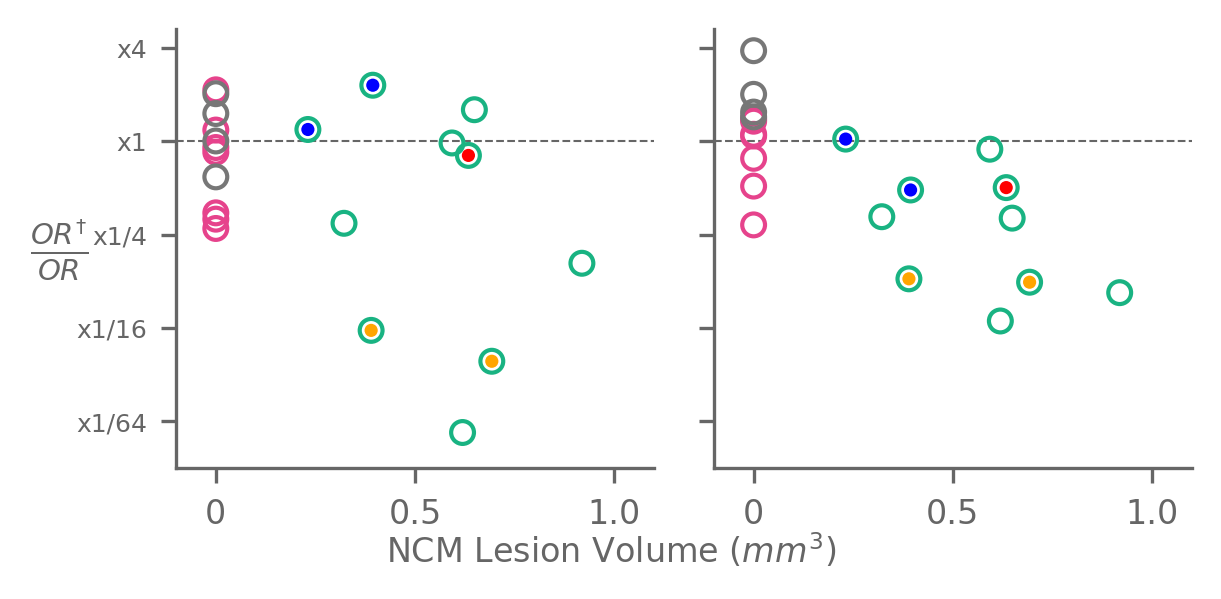

In [11]:
fig = figure_cm(COL1_5 - 1, 5, dpi=300)

axes = fig.subplots(1, 2, sharey=True)#  gridspec_kw={"hspace": 1.0})
figure_S2("SO", ax=axes[0])
figure_S2("DC", ax=axes[1])

axes[0].set_ylabel(r"$\frac{OR^{\dagger}}{OR}$", fontsize=10, verticalalignment="center", rotation=0)

for ax in axes:
    ax.set_xlim(-0.1, 1.1)
    border(ax, 1, 0, 0, 1)
    draw_logor_axes_markers(smallest=-7, biggest=2, convert_log=False, ax=ax)
    ax.set_ylim(-7, 2.4)
    ax.set_xticks([0, 0.5, 1.0], [0, 0.5, 1.0], fontsize=8)

fig.tight_layout()
fig.supxlabel("NCM Lesion Volume ($mm^3$)", fontsize=8)

if SAVE_FIGS:
    fig.savefig(savedir("figS2.svg"), format="svg", bbox_inches="tight")


## Figure S1-1

Comparison of song spectrograms before and after lesion in one HVC lesioned bird. Is associated with figure 1 which has lesion histology.

In [12]:
song_files = defaultdict(list)
for f in glob.glob("../data/behavior/SubjectSongs/*_*.wav"):
    basename = os.path.splitext(os.path.basename(f))[0]
    subject, pre_post, idx = basename.split("_")
    with SoundFile(f) as sndfile:
        song_files[(subject, pre_post)].append({
            "filename": basename,
            "samplerate": sndfile.samplerate,
            "frames": sndfile.frames,
            "data": sndfile.read()
        })
        
offsets = defaultdict(int)
offsets["BluRed8773M_postlesion_0"] = 22050
offsets["RedGra7912M_postlesion_1"] = 22050 // 3
offsets["RedGra7912M_postlesion_3"] = 22050 // 4

color_offsets = defaultdict(int)
color_offsets["BluRed8773M_postlesion_3"] = -20

Figure Dimensions 16.60cm x 6.00cm


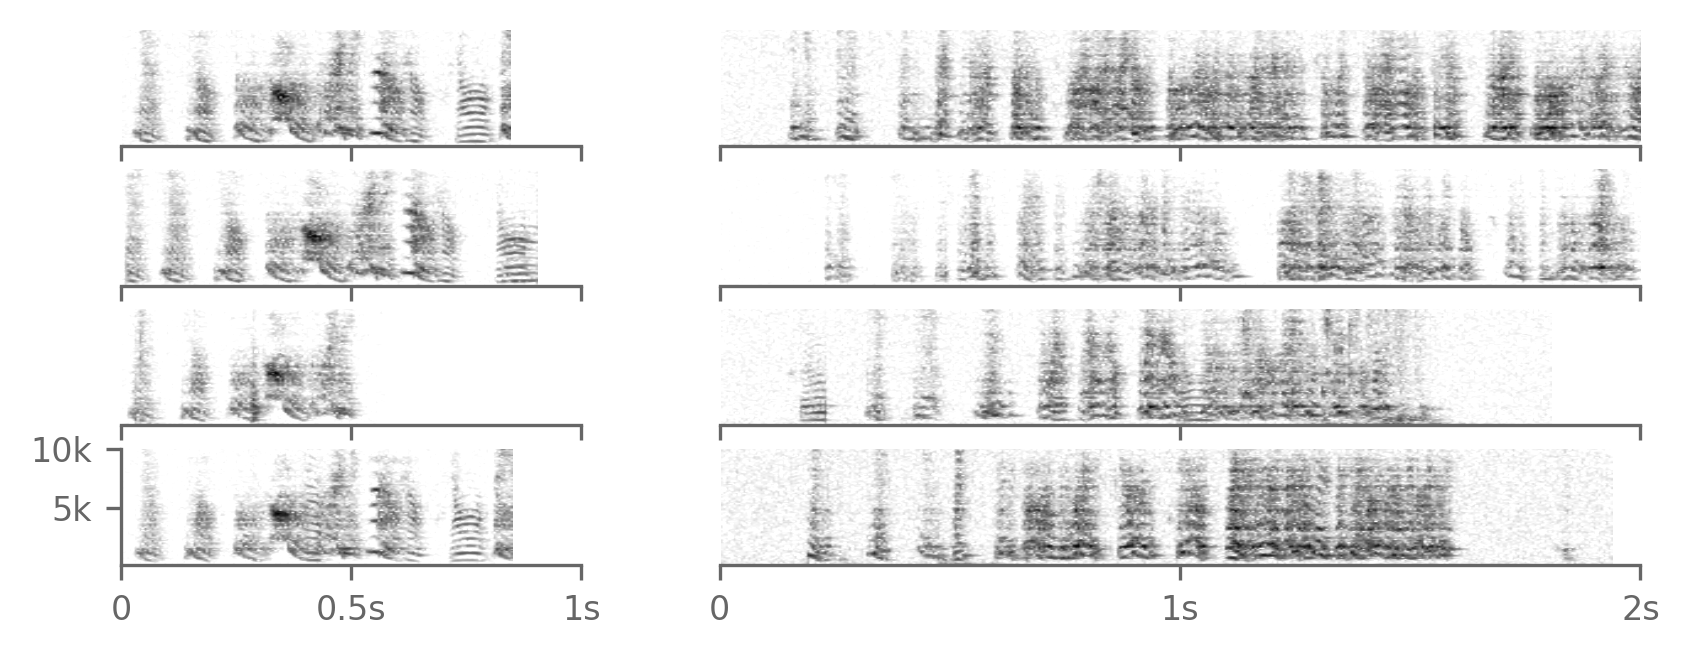

In [13]:
fig = figure_cm(COL2 - 1, 6, dpi=300)
axes = fig.subplots(4, 2, gridspec_kw={"width_ratios": [0.5, 1.0]}, sharex='col')

for i, file_data in enumerate(song_files[("BluRed8773M", "prelesion")]):
    ax = axes[i, 0]
    spec, _, _, im = ax.specgram(file_data["data"], NFFT=512, noverlap=256, mode="psd", Fs=file_data["samplerate"], cmap="Greys", aspect='auto', interpolation='bilinear')
    cmax = np.max(10 * np.log10(spec)) + color_offsets[file_data["filename"]]
    cmin = cmax - 50
    im.set_clim(cmin, cmax)
    ax.set_ylim(250, 10000)
    ax.set_xlim(0, 1.0)
    ax.set_yticks([])
    border(ax, 0, 0, 0, 1)

    
for i, file_data in enumerate(song_files[("BluRed8773M", "postlesion")]):
    ax = axes[i, 1]
    spec, _, _, im = ax.specgram(file_data["data"][offsets[file_data["filename"]]:], NFFT=512, noverlap=256, mode="psd", Fs=file_data["samplerate"], cmap="Greys", aspect='auto', interpolation='bilinear')
    cmax = np.max(10 * np.log10(spec)) + color_offsets[file_data["filename"]]
    cmin = cmax - 50
    im.set_clim(cmin, cmax)
    ax.set_ylim(250, 10000)
    ax.set_xlim(0, 2.0)
    ax.set_yticks([])
    border(ax, 0, 0, 0, 1)
    ax.set_xticks([0, 1.0, 2.0])
    
border(axes[3, 0], 1, 0, 0, 1)
axes[3, 0].set_yticks([5000, 10000], ["5k", "10k"], fontsize=8)
axes[3, 0].set_xticks([0, 0.5, 1.0], ["0", "0.5s", "1s"], fontsize=8)
axes[3, 1].set_xticks([0, 1, 2], ["0", "1s", "2s"], fontsize=8)

if SAVE_FIGS:
    fig.savefig(savedir("figS1-1A.svg"), format="svg", bbox_inches="tight")




Figure Dimensions 16.60cm x 6.00cm


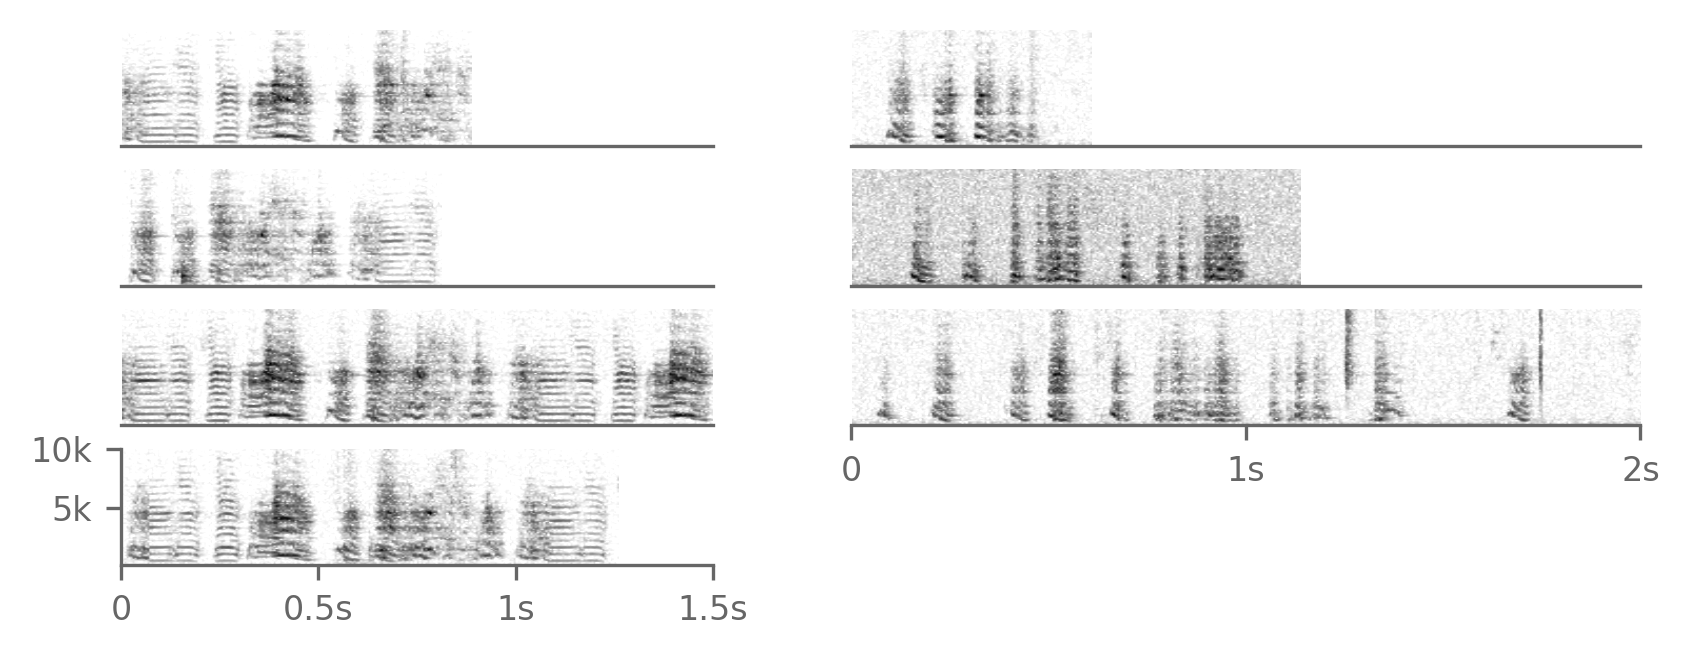

In [14]:
fig = figure_cm(COL2 - 1, 6, dpi=300)
axes = fig.subplots(4, 2, gridspec_kw={"width_ratios": [1.5, 2.0]})

for i, file_data in enumerate(song_files[("BluGre4315M", "prelesion")][:4]):
    ax = axes[i, 0]
    spec, _, _, im = ax.specgram(file_data["data"], NFFT=512, noverlap=256, mode="psd", Fs=file_data["samplerate"], cmap="Greys", aspect='auto', interpolation='bilinear')
    cmax = np.max(10 * np.log10(spec)) + color_offsets[file_data["filename"]]
    cmin = cmax - 50
    im.set_clim(cmin, cmax)
    ax.set_ylim(250, 10000)
    ax.set_xlim(0, 1.5)
    ax.set_yticks([])
    border(ax, 0, 0, 0, 1)
    if i != 3:
        ax.set_xticks([])

    
for i, file_data in enumerate(song_files[("BluGre4315M", "postlesion")][:4]):
    ax = axes[i, 1]
    spec, _, _, im = ax.specgram(file_data["data"][offsets[file_data["filename"]]:], NFFT=512, noverlap=256, mode="psd", Fs=file_data["samplerate"], cmap="Greys", aspect='auto', interpolation='bilinear')
    cmax = np.max(10 * np.log10(spec)) + color_offsets[file_data["filename"]]
    cmin = cmax - 50
    im.set_clim(cmin, cmax)
    ax.set_ylim(250, 10000)
    ax.set_xlim(0, 2.0)
    ax.set_yticks([])
    border(ax, 0, 0, 0, 1)
    ax.set_xticks([0, 1.0, 2.0])
    if i != 2:
        ax.set_xticks([])

border(axes[3, 0], 1, 0, 0, 1)
axes[3, 0].set_yticks([5000, 10000], ["5k", "10k"], fontsize=8)
axes[3, 0].set_xticks([0, 0.5, 1.0, 1.5], ["0", "0.5s", "1s", "1.5s"], fontsize=8)
axes[2, 1].set_xticks([0, 1, 2], ["0", "1s", "2s"], fontsize=8)

axes[3, 1].remove()

if SAVE_FIGS:
    fig.savefig(savedir("figS1-1B.svg"), format="svg", bbox_inches="tight")

Figure Dimensions 16.60cm x 6.00cm


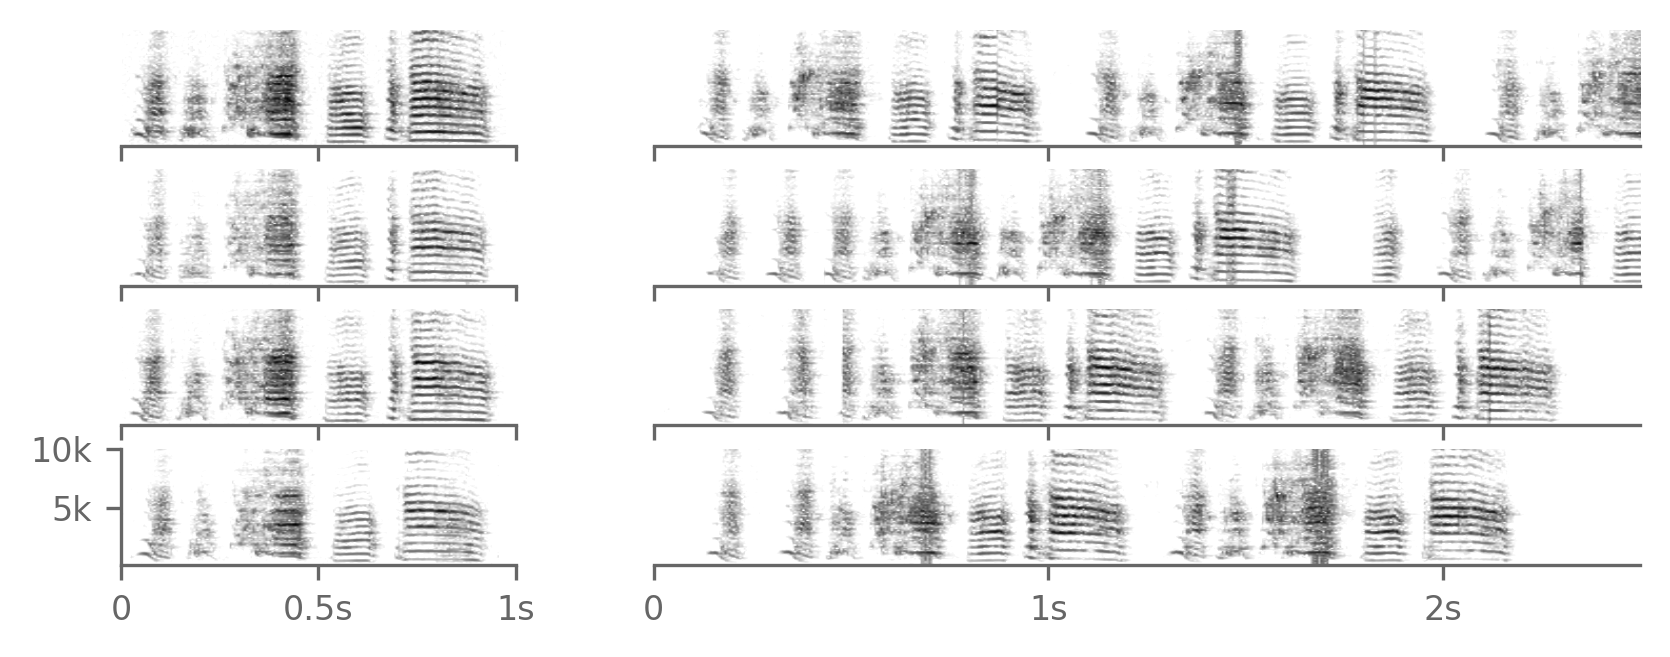

In [15]:
fig = figure_cm(COL2 - 1, 6, dpi=300)
axes = fig.subplots(4, 2, gridspec_kw={"width_ratios": [1, 2.5]}, sharex='col')

for i, file_data in enumerate(song_files[("RedGra7912M", "prelesion")][:4]):
    ax = axes[i, 0]
    spec, _, _, im = ax.specgram(file_data["data"], NFFT=512, noverlap=256, mode="psd", Fs=file_data["samplerate"], cmap="Greys", aspect='auto', interpolation='bilinear')
    cmax = np.max(10 * np.log10(spec)) + color_offsets[file_data["filename"]]
    cmin = cmax - 50
    im.set_clim(cmin, cmax)
    ax.set_ylim(250, 10000)
    ax.set_xlim(0, 1.0)
    ax.set_yticks([])
    border(ax, 0, 0, 0, 1)

    
for i, file_data in enumerate(song_files[("RedGra7912M", "postlesion")][:4]):
    ax = axes[i, 1]
    spec, _, _, im = ax.specgram(file_data["data"][offsets[file_data["filename"]]:], NFFT=512, noverlap=256, mode="psd", Fs=file_data["samplerate"], cmap="Greys", aspect='auto', interpolation='bilinear')
    cmax = np.max(10 * np.log10(spec)) + color_offsets[file_data["filename"]]
    cmin = cmax - 50
    im.set_clim(cmin, cmax)
    ax.set_ylim(250, 10000)
    ax.set_xlim(0, 2.5)
    ax.set_yticks([])
    border(ax, 0, 0, 0, 1)
    ax.set_xticks([0, 1.0, 2.0])
    
border(axes[3, 0], 1, 0, 0, 1)
axes[3, 0].set_yticks([5000, 10000], ["5k", "10k"], fontsize=8)
axes[3, 0].set_xticks([0, 0.5, 1.0], ["0", "0.5s", "1s"], fontsize=8)
axes[3, 1].set_xticks([0, 1, 2], ["0", "1s", "2s"], fontsize=8)

if SAVE_FIGS:
    fig.savefig(savedir("figS1-1C.svg"), format="svg", bbox_inches="tight")


